# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 9.9 MB/s 
     |████████████████████████████████| 376 kB 70.0 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=48ea87f19be33edbf149efe2f23536a805cec635cf0f1d6e7ca456598a68ab1f
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=9eb36e76178e86c7a583c84340409b90f0b29333563655fb0b1d8590072aedfe
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning ht

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 8.00 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
!unzip /content/anomaly_dataset.zip

Archive:  /content/anomaly_dataset.zip
replace anomaly_dataset/images/004.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace anomaly_dataset/images/005.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: n,A
replace anomaly_dataset/images/006.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
img_files = os.listdir("/content/anomaly_dataset/images")
img_files.sort()
mask_files = os.listdir("/content/anomaly_dataset/labels")
mask_files.sort()

In [ ]:
import csv

# open the file in the write mode
with open('/content/train.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(['Images','Masks'])

    for i in range(len(img_files)):
      writer.writerow([img_files[i],mask_files[i]])


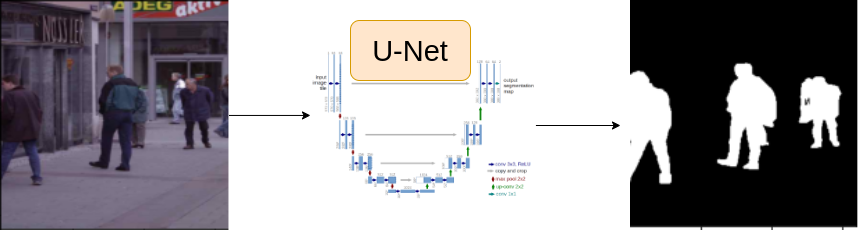

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helpfunc

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = "/content/train.csv"
DATA_DIR = "/content/"

DEVICE = 'cuda'

EPOCHS = 100
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [ ]:
cd /content/anomaly_dataset

/content/anomaly_dataset


In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

Images    Masks
0  004.JPG  004.png
1  005.JPG  005.png
2  006.JPG  006.png
3  007.JPG  007.png
4  009.JPG  009.png

In [ ]:
row = df.iloc[4]

image_path = os.path.join('/content/anomaly_dataset/images',row.Images)

mask_path = os.path.join('/content/anomaly_dataset/labels',row.Masks)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

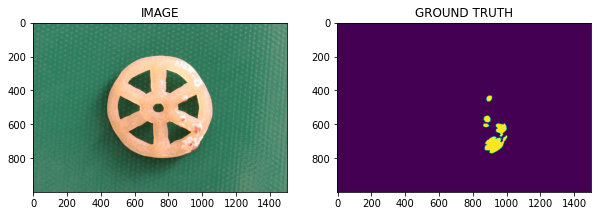

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
#ax2.imshow(mask,cmap = 'gray')
ax2.imshow(mask)

In [ ]:
train_df, valid_df = train_test_split(df, test_size =0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],is_check_shapes =False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ],is_check_shapes =False) 

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    image_path = os.path.join('/content/anomaly_dataset/images',row.Images)
    #print(image_path)
    mask_path = os.path.join('/content/anomaly_dataset/labels',row.Masks)
    #print(mask_path)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image,mask=mask)
      image = data['image']
      mask = data['mask']


    #(h,w,c) -> (c,h,w)
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask= np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    #mask = torch.round(torch.Tensor(mask)/255.0)
    mask = (torch.Tensor(mask)/255.0)

    return image,mask



In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 48
Size of Validset : 12


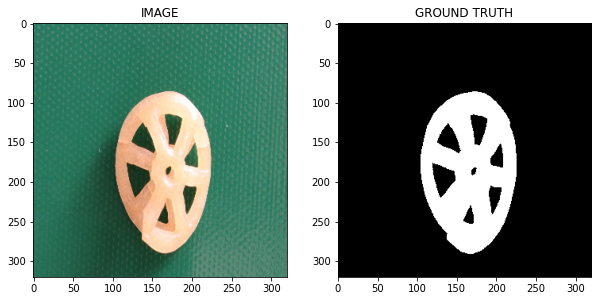

In [ ]:

idx = 35
image,mask = trainset[idx]
helpfunc.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in train loader: {len(trainloader)}")
print(f"Total no. of batches in valid loader: {len(validloader)}")

Total no. of batches in train loader: 3
Total no. of batches in valid loader: 1


In [ ]:
for image,mask in validloader:
  break
print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([12, 3, 320, 320])
One batch mask shape: torch.Size([12, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss,FocalLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks=None):
    logits = self.arc(images)

    if masks!=None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      loss = FocalLoss(mode='binary')(logits,masks)
      #return logits, loss1 + loss2
      return logits, loss
    
    return logits 



In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0

  for images,masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)  


In [ ]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      optimizer.zero_grad()
      logits,loss = model(images,masks)

      total_loss+=loss.item()

    return total_loss/len(data_loader)  

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(validloader,model)


  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('SAVED-MODEL')
    best_valid_loss  =valid_loss

  print(f'Epoch: {i+1} Train_loss: {train_loss} Valid_loss:{valid_loss}')

100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


SAVED-MODEL
Epoch: 1 Train_loss: 0.2506226897239685 Valid_loss:1.9593597650527954


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


SAVED-MODEL
Epoch: 2 Train_loss: 0.07923534512519836 Valid_loss:0.06939654052257538


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch: 3 Train_loss: 0.03246322522560755 Valid_loss:0.14718417823314667


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch: 4 Train_loss: 0.01802628052731355 Valid_loss:0.1673726886510849


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 5 Train_loss: 0.012446174087623755 Valid_loss:0.2769536077976227


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 6 Train_loss: 0.010017491411417723 Valid_loss:0.12059936672449112


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


SAVED-MODEL
Epoch: 7 Train_loss: 0.008715331088751554 Valid_loss:0.011453180573880672


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


SAVED-MODEL
Epoch: 8 Train_loss: 0.007862680436422428 Valid_loss:0.008195390924811363


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


SAVED-MODEL
Epoch: 9 Train_loss: 0.007466477807611227 Valid_loss:0.005399861838668585


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


SAVED-MODEL
Epoch: 10 Train_loss: 0.007150713354349136 Valid_loss:0.0049758548848330975


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


SAVED-MODEL
Epoch: 11 Train_loss: 0.0067613062759240465 Valid_loss:0.003512958064675331


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch: 12 Train_loss: 0.006701243886103232 Valid_loss:0.003623881144449115


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


SAVED-MODEL
Epoch: 13 Train_loss: 0.0065546392773588496 Valid_loss:0.0034681097604334354


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch: 14 Train_loss: 0.006450656956682603 Valid_loss:0.005858743563294411


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch: 15 Train_loss: 0.006348768559594949 Valid_loss:0.005001281388103962


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch: 16 Train_loss: 0.006373281124979258 Valid_loss:0.004962428472936153


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch: 17 Train_loss: 0.006417687749490142 Valid_loss:0.004053608514368534


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch: 18 Train_loss: 0.006211807175228993 Valid_loss:0.004915584810078144


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch: 19 Train_loss: 0.0062254429794847965 Valid_loss:0.005315203219652176


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch: 20 Train_loss: 0.006187786969045798 Valid_loss:0.005336220841854811


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


SAVED-MODEL
Epoch: 21 Train_loss: 0.0064550102688372135 Valid_loss:0.002665306907147169


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch: 22 Train_loss: 0.006500790361315012 Valid_loss:0.003393701743334532


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch: 23 Train_loss: 0.006311751281221707 Valid_loss:0.0035894375760108232


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch: 24 Train_loss: 0.006186650134623051 Valid_loss:0.0029927194118499756


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


SAVED-MODEL
Epoch: 25 Train_loss: 0.00610687118023634 Valid_loss:0.002585285808891058


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


SAVED-MODEL
Epoch: 26 Train_loss: 0.006043408531695604 Valid_loss:0.0025616122875362635


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


SAVED-MODEL
Epoch: 27 Train_loss: 0.006235721055418253 Valid_loss:0.002553800353780389


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch: 28 Train_loss: 0.00616498136272033 Valid_loss:0.0025775509420782328


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch: 29 Train_loss: 0.006122776307165623 Valid_loss:0.0026471551973372698


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 30 Train_loss: 0.006103191679964463 Valid_loss:0.002718887524679303


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch: 31 Train_loss: 0.005994371138513088 Valid_loss:0.002570154843851924


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


SAVED-MODEL
Epoch: 32 Train_loss: 0.005992318658779065 Valid_loss:0.0025398859288543463


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 33 Train_loss: 0.006156219635158777 Valid_loss:0.0027586137875914574


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch: 34 Train_loss: 0.006209004204720259 Valid_loss:0.002840842120349407


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch: 35 Train_loss: 0.006029825968046983 Valid_loss:0.003325059311464429


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch: 36 Train_loss: 0.006002397586901982 Valid_loss:0.0029206108301877975


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 37 Train_loss: 0.006001306387285392 Valid_loss:0.002571721328422427


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


SAVED-MODEL
Epoch: 38 Train_loss: 0.005939965757230918 Valid_loss:0.00253849639557302


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch: 39 Train_loss: 0.005945876085509856 Valid_loss:0.0026046927087008953


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch: 40 Train_loss: 0.005930936274429162 Valid_loss:0.0027192775160074234


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch: 41 Train_loss: 0.005953238423292835 Valid_loss:0.0028507988899946213


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch: 42 Train_loss: 0.0062144917125503225 Valid_loss:0.0037620526272803545


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch: 43 Train_loss: 0.006068931582073371 Valid_loss:0.003959644120186567


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch: 44 Train_loss: 0.006008314744879802 Valid_loss:0.0039020085241645575


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 45 Train_loss: 0.006093879618371527 Valid_loss:0.0038006568793207407


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch: 46 Train_loss: 0.006306645926088095 Valid_loss:0.002721738535910845


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 47 Train_loss: 0.006090132519602776 Valid_loss:0.0026701795868575573


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch: 48 Train_loss: 0.00628404738381505 Valid_loss:0.002584962174296379


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


SAVED-MODEL
Epoch: 49 Train_loss: 0.006201594757537047 Valid_loss:0.0025120817590504885


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


SAVED-MODEL
Epoch: 50 Train_loss: 0.006063794096310933 Valid_loss:0.0025009915698319674


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


SAVED-MODEL
Epoch: 51 Train_loss: 0.0061522419564425945 Valid_loss:0.0024903519079089165


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


SAVED-MODEL
Epoch: 52 Train_loss: 0.006291133584454656 Valid_loss:0.0024721617810428143


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch: 53 Train_loss: 0.0061504825328787165 Valid_loss:0.0024945931509137154


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch: 54 Train_loss: 0.005974810880919297 Valid_loss:0.002567260293290019


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch: 55 Train_loss: 0.005958167836070061 Valid_loss:0.0025600637309253216


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch: 56 Train_loss: 0.005975726991891861 Valid_loss:0.0025069895200431347


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


SAVED-MODEL
Epoch: 57 Train_loss: 0.006007527932524681 Valid_loss:0.002461866708472371


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


SAVED-MODEL
Epoch: 58 Train_loss: 0.0059192680443326635 Valid_loss:0.002445918507874012


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 59 Train_loss: 0.0060975218657404184 Valid_loss:0.0025605931878089905


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch: 60 Train_loss: 0.005858547209451596 Valid_loss:0.0026034412439912558


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch: 61 Train_loss: 0.005881853013609846 Valid_loss:0.0026345900259912014


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch: 62 Train_loss: 0.005888168700039387 Valid_loss:0.002778966212645173


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch: 63 Train_loss: 0.005918758960130314 Valid_loss:0.0026165759190917015


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch: 64 Train_loss: 0.0058322118905683356 Valid_loss:0.0025761588476598263


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 65 Train_loss: 0.005826920426140229 Valid_loss:0.002549055963754654


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch: 66 Train_loss: 0.006404346941659848 Valid_loss:0.002456408692523837


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch: 67 Train_loss: 0.005993837839923799 Valid_loss:0.0025673506315797567


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch: 68 Train_loss: 0.0059478264302015305 Valid_loss:0.002591427182778716


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 69 Train_loss: 0.005897192284464836 Valid_loss:0.002469598548486829


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


SAVED-MODEL
Epoch: 70 Train_loss: 0.0059018428437411785 Valid_loss:0.0024414921645075083


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


SAVED-MODEL
Epoch: 71 Train_loss: 0.005985633858169119 Valid_loss:0.0024252007715404034


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


SAVED-MODEL
Epoch: 72 Train_loss: 0.005865273609136541 Valid_loss:0.0024237465113401413


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


SAVED-MODEL
Epoch: 73 Train_loss: 0.006002245742517213 Valid_loss:0.0024201362393796444


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch: 74 Train_loss: 0.0058370061839620275 Valid_loss:0.0024223357904702425


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Epoch: 75 Train_loss: 0.005912918442239364 Valid_loss:0.00266886199824512


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch: 76 Train_loss: 0.006204103430112203 Valid_loss:0.0024728644639253616


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch: 77 Train_loss: 0.005971675195420782 Valid_loss:0.0024849658366292715


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Epoch: 78 Train_loss: 0.006091568153351545 Valid_loss:0.00250346795655787


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch: 79 Train_loss: 0.005983074816564719 Valid_loss:0.0026648775674402714


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch: 80 Train_loss: 0.005824276090910037 Valid_loss:0.0028799171559512615


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Epoch: 81 Train_loss: 0.006102099238584439 Valid_loss:0.0025929794646799564


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch: 82 Train_loss: 0.005993949559827645 Valid_loss:0.0025214299093931913


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 83 Train_loss: 0.0058481422408173485 Valid_loss:0.002578494604676962


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch: 84 Train_loss: 0.00599107068652908 Valid_loss:0.0025854327250272036


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch: 85 Train_loss: 0.006147233924518029 Valid_loss:0.0025339138228446245


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch: 86 Train_loss: 0.0061176928381125135 Valid_loss:0.0025082267820835114


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 87 Train_loss: 0.006264630084236463 Valid_loss:0.0025690242182463408


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch: 88 Train_loss: 0.0062421588227152824 Valid_loss:0.002679230412468314


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch: 89 Train_loss: 0.006056694469104211 Valid_loss:0.0026714785490185022


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch: 90 Train_loss: 0.00602227922839423 Valid_loss:0.0025124563835561275


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch: 91 Train_loss: 0.005825789334873359 Valid_loss:0.002443961799144745


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


SAVED-MODEL
Epoch: 92 Train_loss: 0.005835534539073706 Valid_loss:0.002379087498411536


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


SAVED-MODEL
Epoch: 93 Train_loss: 0.005819466430693865 Valid_loss:0.002372367074713111


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


SAVED-MODEL
Epoch: 94 Train_loss: 0.005804472758124272 Valid_loss:0.002370290458202362


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


SAVED-MODEL
Epoch: 95 Train_loss: 0.005782338324934244 Valid_loss:0.002370136324316263


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


SAVED-MODEL
Epoch: 96 Train_loss: 0.005774583201855421 Valid_loss:0.002369303721934557


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


SAVED-MODEL
Epoch: 97 Train_loss: 0.005780599856128295 Valid_loss:0.0023679141886532307


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


SAVED-MODEL
Epoch: 98 Train_loss: 0.0057738156368335085 Valid_loss:0.002366004977375269


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


SAVED-MODEL
Epoch: 99 Train_loss: 0.005761364630113046 Valid_loss:0.0023641122970730066


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

SAVED-MODEL
Epoch: 100 Train_loss: 0.005779156073306997 Valid_loss:0.0023632484953850508


# Task 9 : Inference

In [ ]:
idx = 1
model.load_state_dict(torch.load('/content/anomaly_dataset/best_model.pt'))

image,mask = trainset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

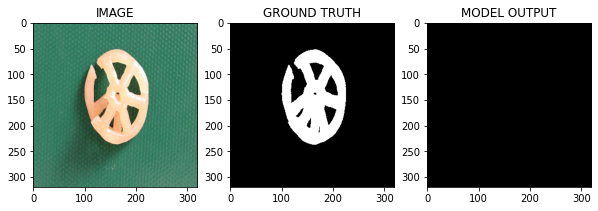

In [ ]:
helpfunc.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

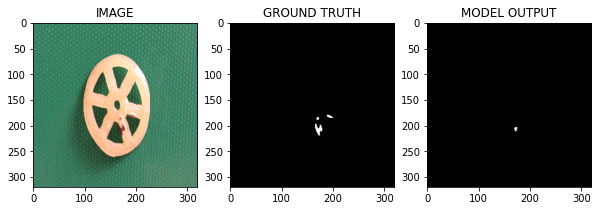

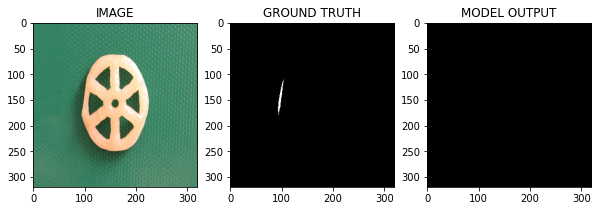

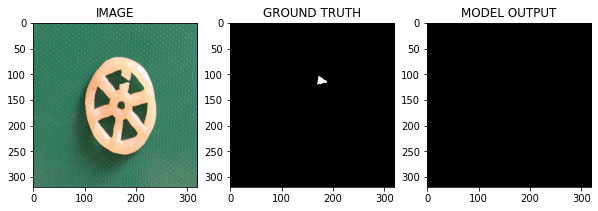

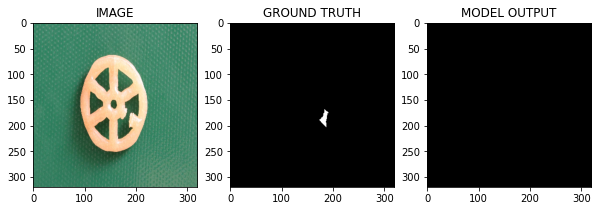

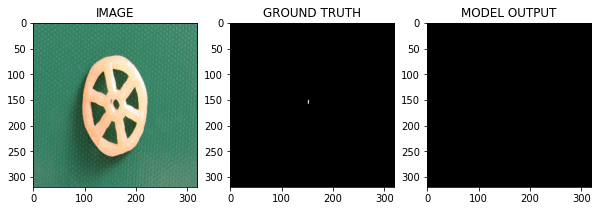

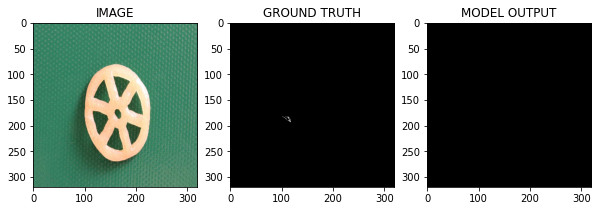

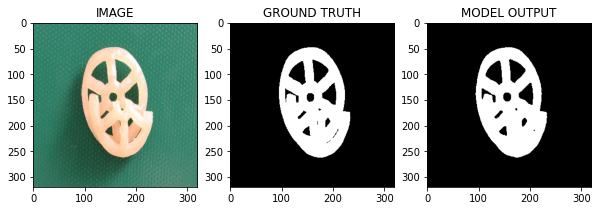

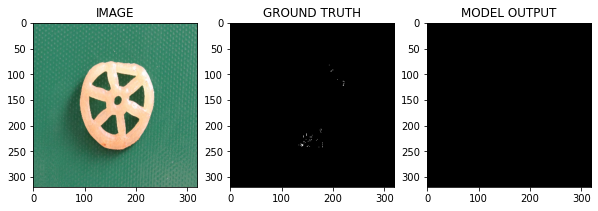

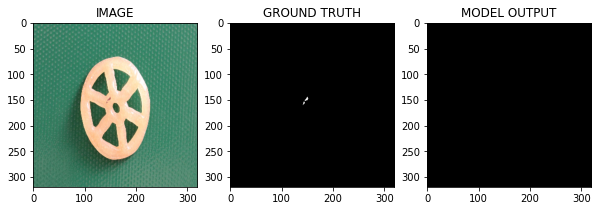

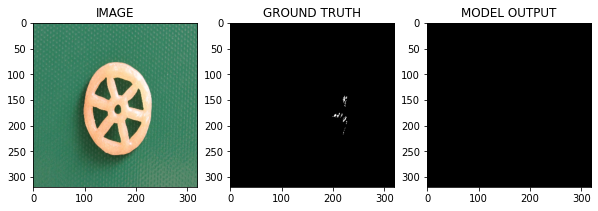

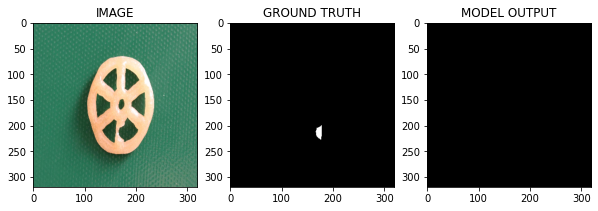

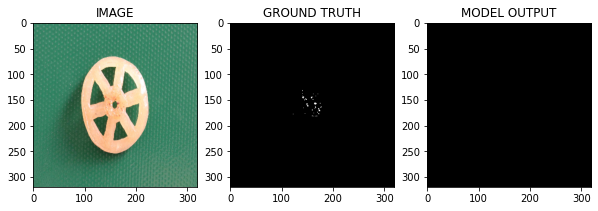

In [ ]:
for i in range(12):
  model.load_state_dict(torch.load('/content/anomaly_dataset/best_model.pt'))

  image,mask = validset[i]

  logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask>0.5)*1.0

  helpfunc.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

/content/Human-Segmentation-Dataset-master/helpfunc.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))


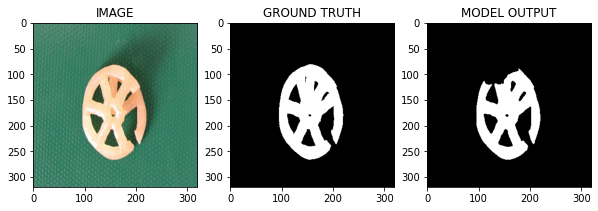

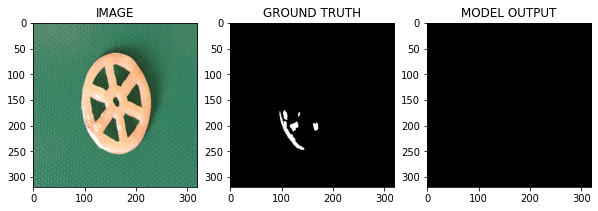

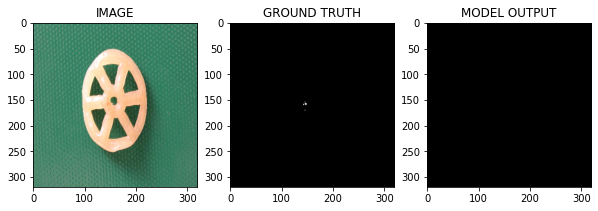

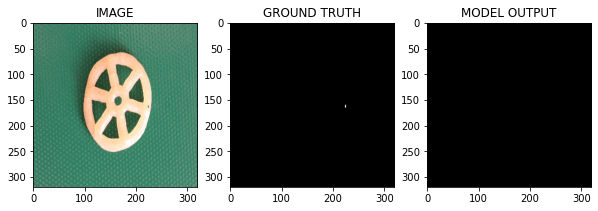

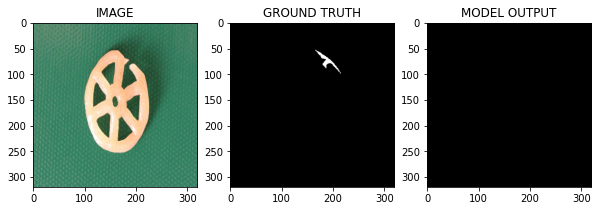

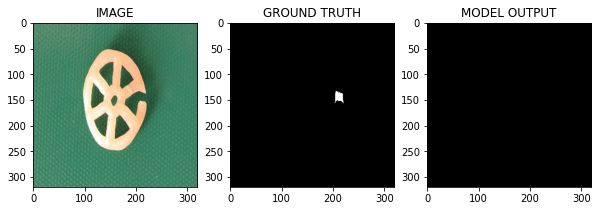

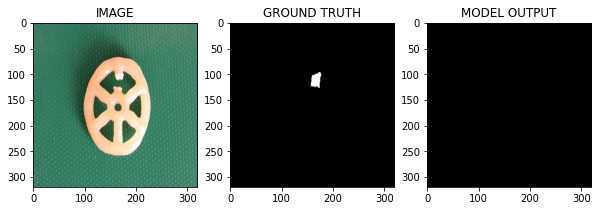

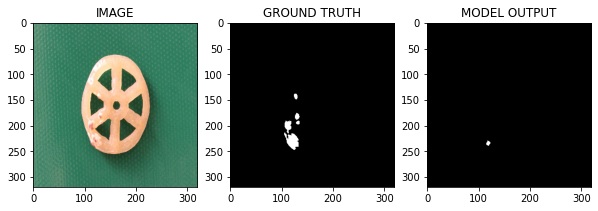

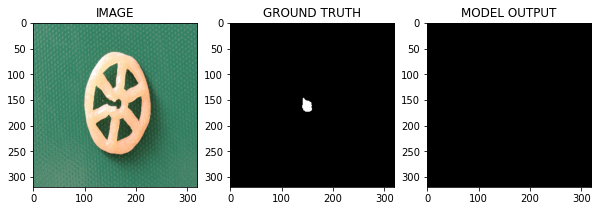

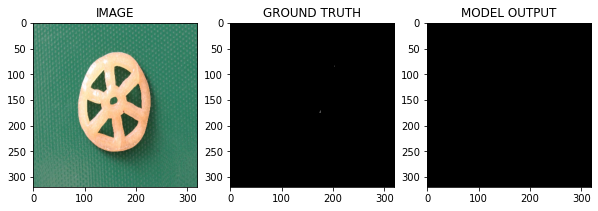

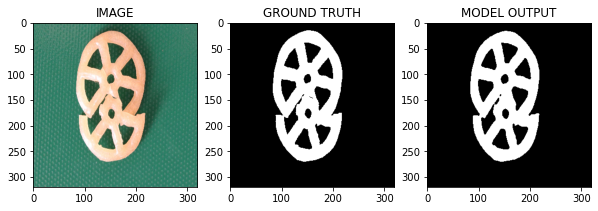

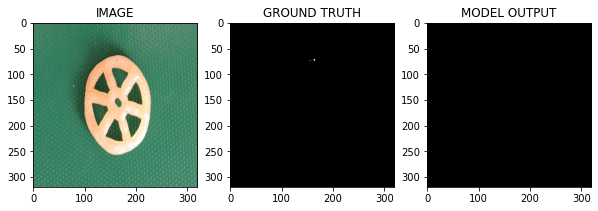

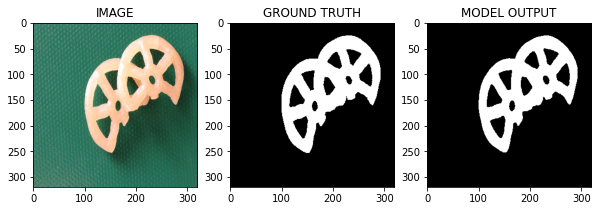

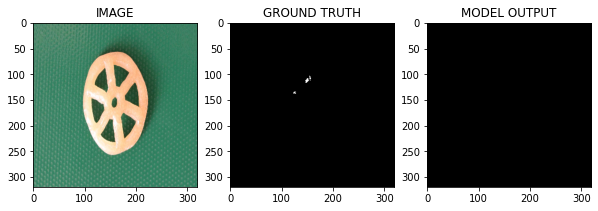

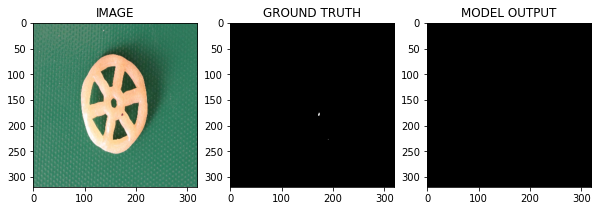

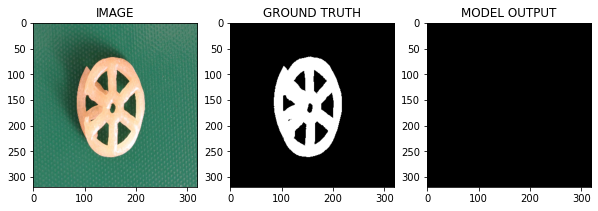

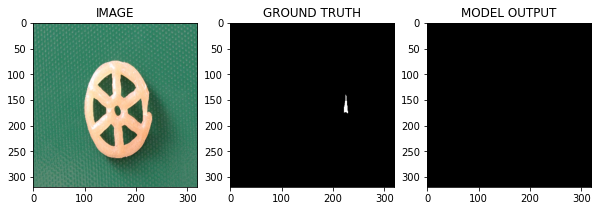

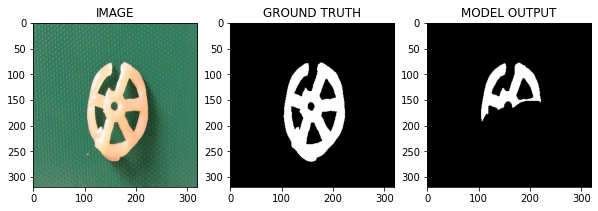

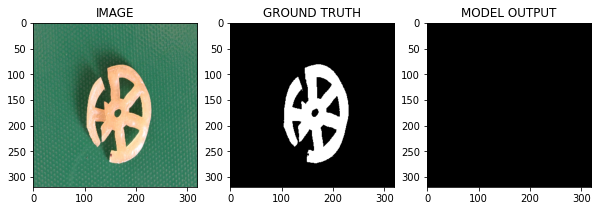

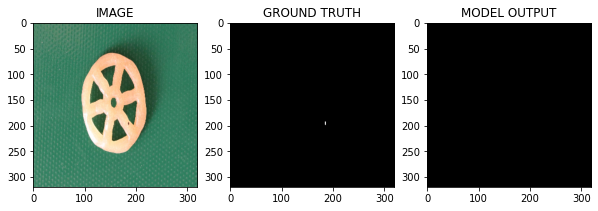

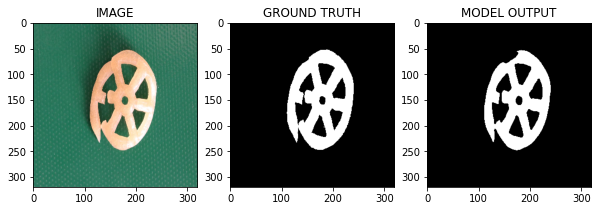

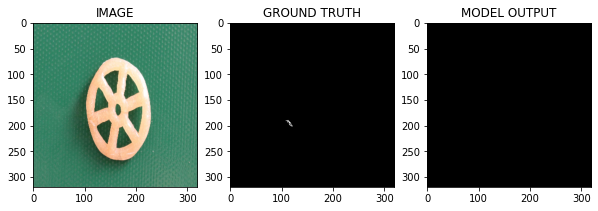

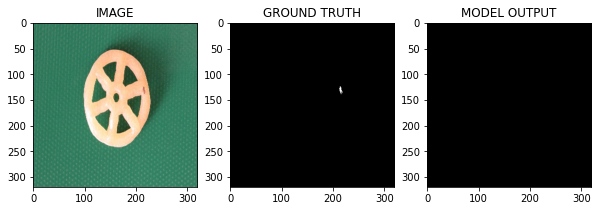

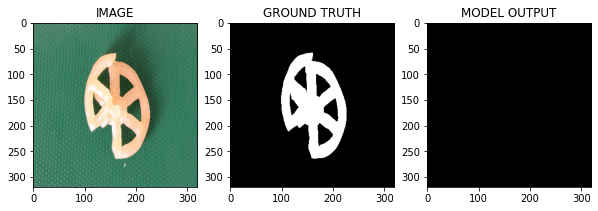

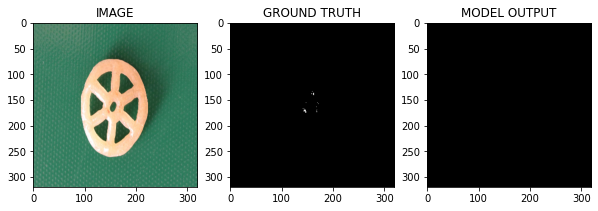

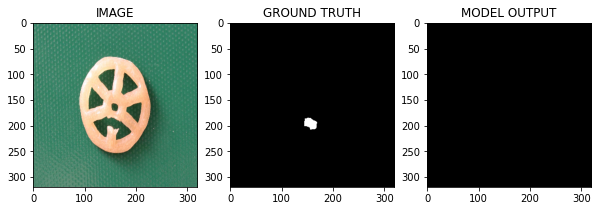

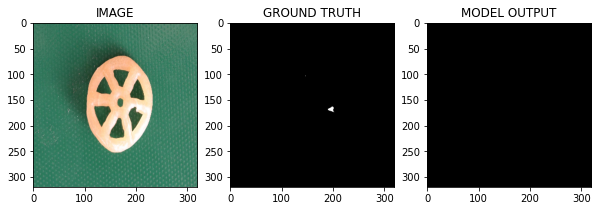

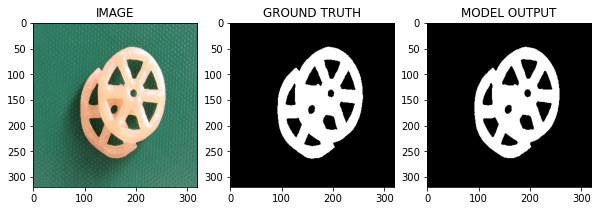

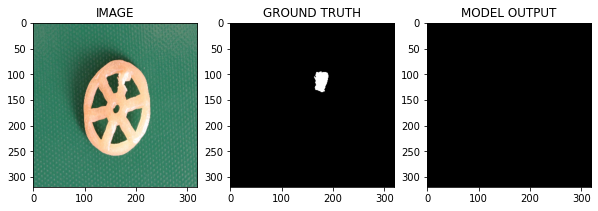

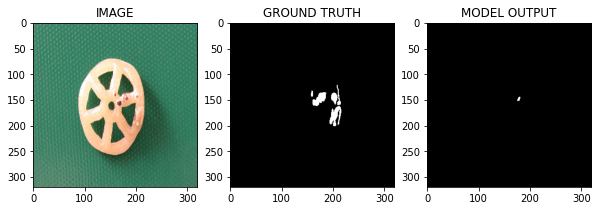

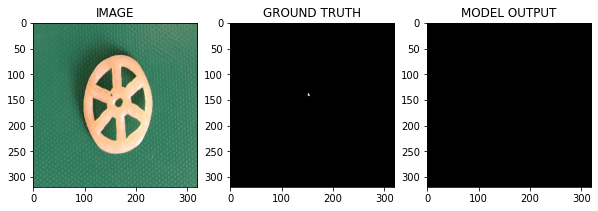

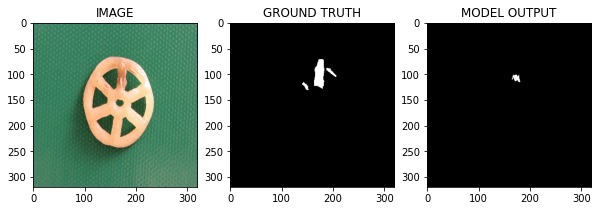

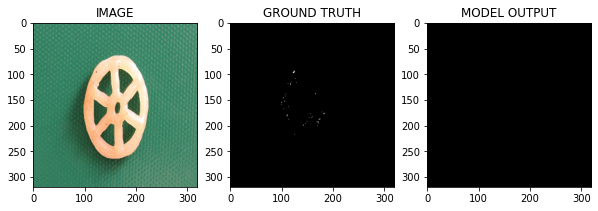

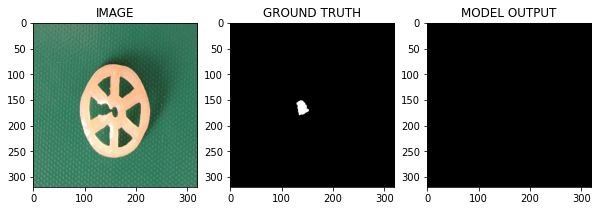

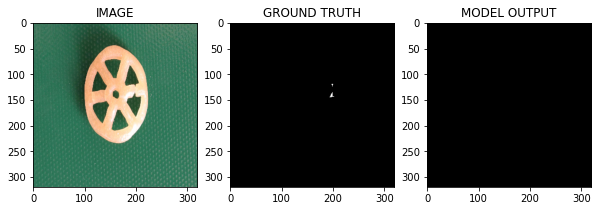

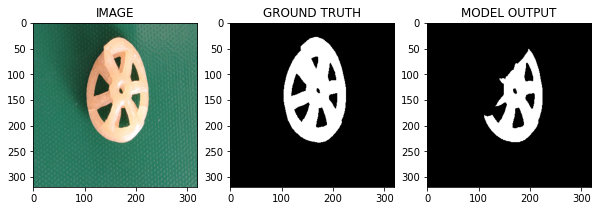

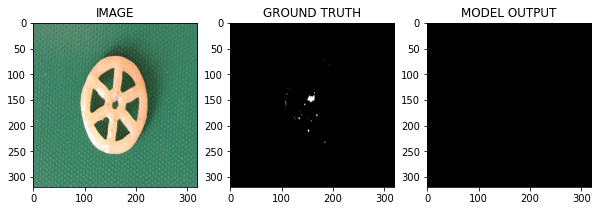

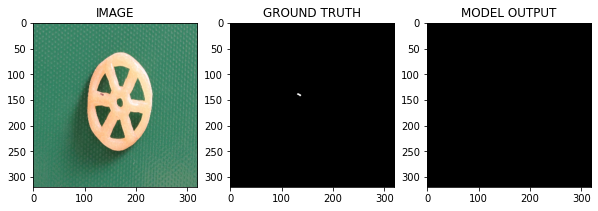

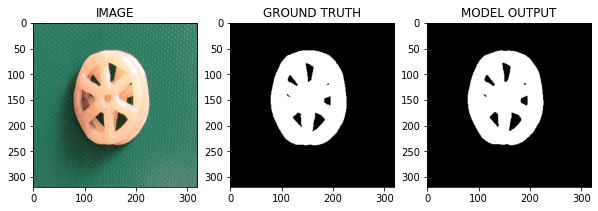

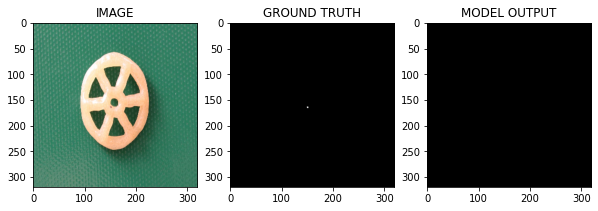

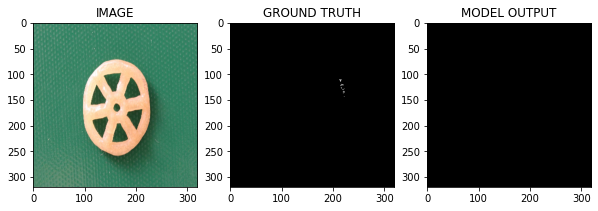

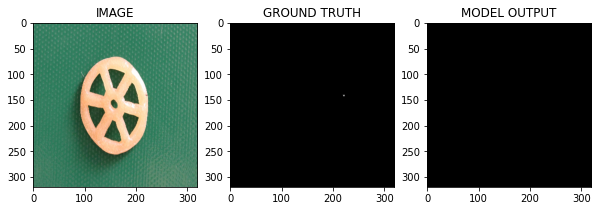

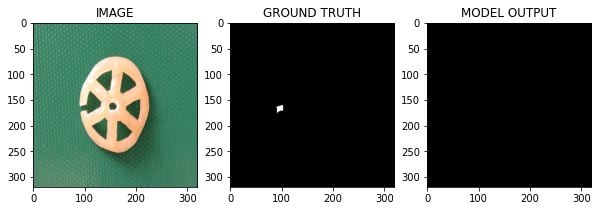

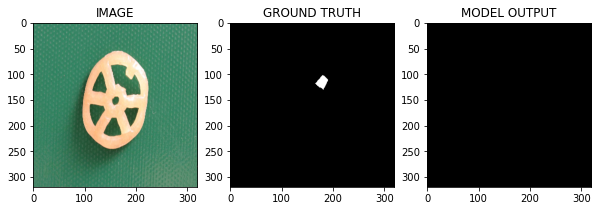

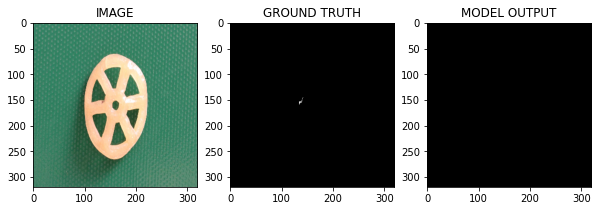

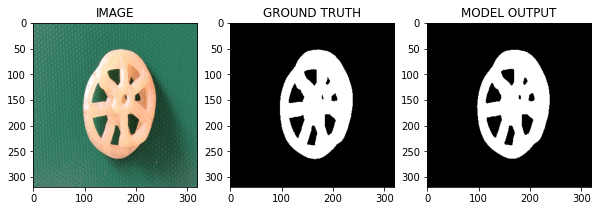

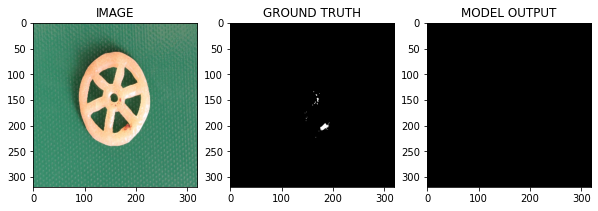

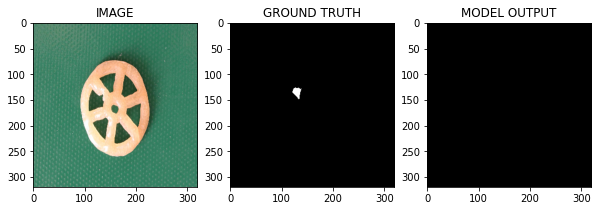

In [ ]:
for i in range(48):
  model.load_state_dict(torch.load('/content/anomaly_dataset/best_model.pt'))

  image,mask = trainset[i]

  logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask>0.5)*1.0

  helpfunc.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

In [ ]:

model.load_state_dict(torch.load('/content/anomaly_dataset/best_model.pt'))

image = cv2.imread('/content/069.JPG')
image = cv2.resize(image, (320,320))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.transpose(image,(2,0,1)).astype(np.float32)
image = torch.Tensor(image)/255

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

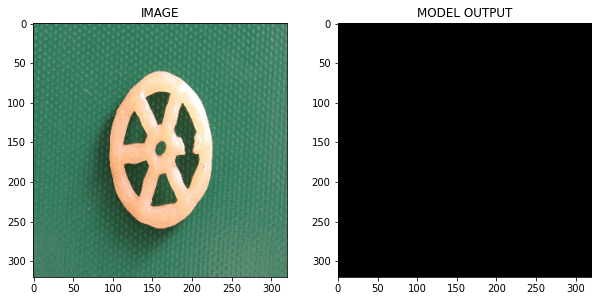

In [ ]:
helpfunc.show_image(image=image,mask=None,pred_image=pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya